In [16]:
# 0. Imports & settings
import os, warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
pd.options.display.max_columns = 200

# ML tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print('Working dir:', os.getcwd())
print('/content', os.listdir('/content'))

Working dir: /content
/content ['.config', 'submission.csv', 'test.csv', 'train.csv', 'sample_data']


In [17]:
# 1. Load data
TRAIN_PATH = '/content/train.csv'
TEST_PATH = '/content/test.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()

Train shape: (67463, 35)
Test shape: (28913, 35)


,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [18]:
train.columns

Index(['ID', 'Loan Amount', 'Funded Amount', 'Funded Amount Investor', 'Term',
       'Batch Enrolled', 'Interest Rate', 'Grade', 'Sub Grade',
       'Employment Duration', 'Home Ownership', 'Verification Status',
       'Payment Plan', 'Loan Title', 'Debit to Income',
       'Delinquency - two years', 'Inquires - six months', 'Open Account',
       'Public Record', 'Revolving Balance', 'Revolving Utilities',
       'Total Accounts', 'Initial List Status', 'Total Received Interest',
       'Total Received Late Fee', 'Recoveries', 'Collection Recovery Fee',
       'Collection 12 months Medical', 'Application Type', 'Last week Pay',
       'Accounts Delinquent', 'Total Collection Amount',
       'Total Current Balance', 'Total Revolving Credit Limit', 'Loan Status'],
      dtype='object')

In [19]:
# 2. Target and quick DQR
TARGET = 'Loan Status'

print('Target distribution:')
print(train[TARGET].value_counts(dropna=False))
print('\nTarget proportions:')
print((train[TARGET].value_counts(normalize=True)).round(4))

# Basic DQR
dqr = pd.DataFrame({
    'dtype': train.dtypes.astype(str),
    'n_missing': train.isnull().sum(),
    'pct_missing': (train.isnull().mean()*100).round(2),
    'n_unique': train.nunique()
}).sort_values('pct_missing', ascending=False)

Target distribution:
Loan Status
0    61222
1     6241
Name: count, dtype: int64

Target proportions:
Loan Status
0    0.9075
1    0.0925
Name: proportion, dtype: float64


In [20]:
print(dqr)

                                dtype  n_missing  pct_missing  n_unique
ID                              int64          0          0.0     67463
Loan Amount                     int64          0          0.0     27525
Funded Amount                   int64          0          0.0     24548
Funded Amount Investor        float64          0          0.0     67441
Term                            int64          0          0.0         3
Batch Enrolled                 object          0          0.0        41
Interest Rate                 float64          0          0.0     67448
Grade                          object          0          0.0         7
Sub Grade                      object          0          0.0        35
Employment Duration            object          0          0.0         3
Home Ownership                float64          0          0.0     67454
Verification Status            object          0          0.0         3
Payment Plan                   object          0          0.0   

In [21]:
train.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [22]:
# 3. Column typing
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in train.columns if c not in num_cols and c != TARGET]
# remove id-like
id_cols = [c for c in train.columns if c.lower().startswith('id') or c.lower().endswith('id')]
num_cols = [c for c in num_cols if c not in id_cols and c!=TARGET]

print('Numeric:', len(num_cols), 'Categorical:', len(cat_cols), 'ID-like:', id_cols)
num_cols[:10], cat_cols[:10]

Numeric: 24 Categorical: 9 ID-like: ['ID']


(['Loan Amount',
  'Funded Amount',
  'Funded Amount Investor',
  'Term',
  'Interest Rate',
  'Home Ownership',
  'Debit to Income',
  'Delinquency - two years',
  'Inquires - six months',
  'Open Account'],
 ['Batch Enrolled',
  'Grade',
  'Sub Grade',
  'Employment Duration',
  'Verification Status',
  'Payment Plan',
  'Loan Title',
  'Initial List Status',
  'Application Type'])

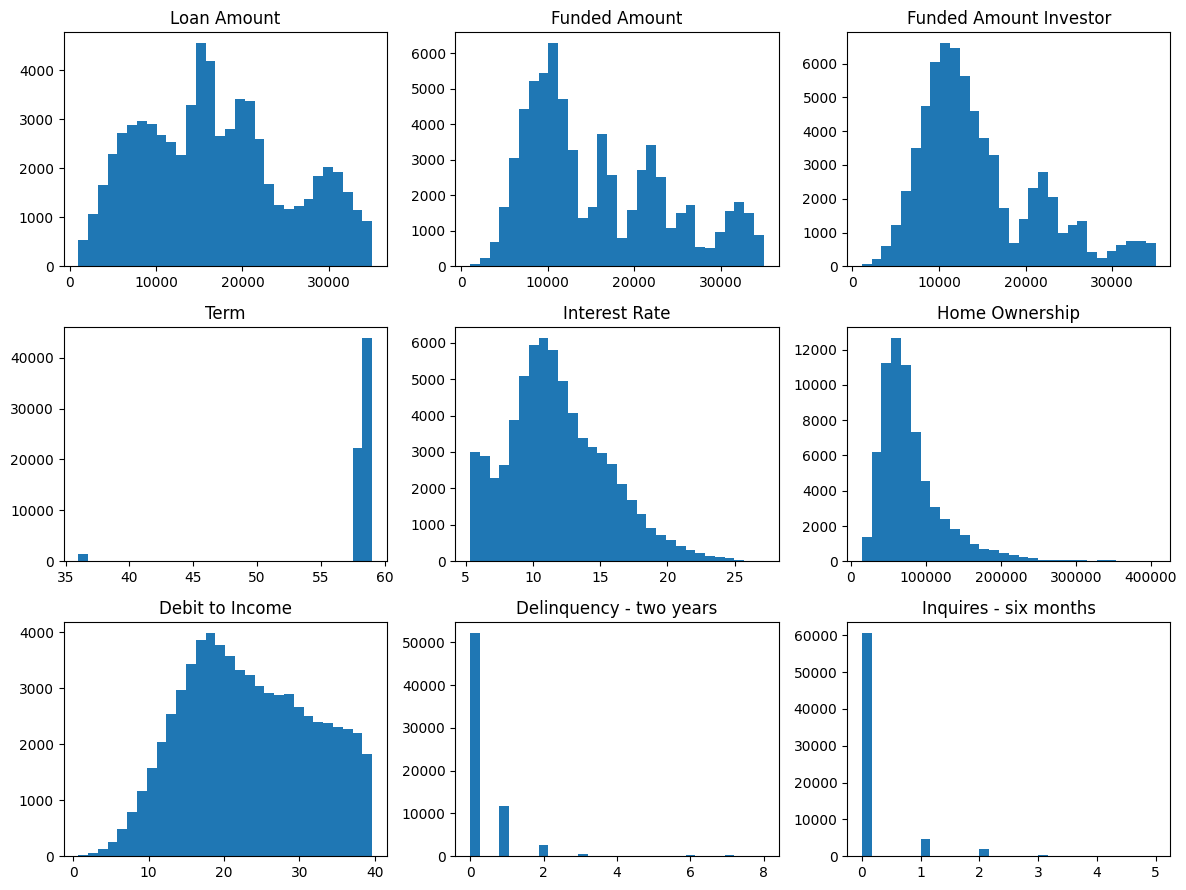


Top values for Batch Enrolled


,count
Batch Enrolled,
BAT3873588,3626
BAT1586599,3142
BAT1104812,2996
BAT2252229,2557
BAT2803411,2425
BAT1780517,2403
BAT1184694,2298
BAT2078974,2290



Top values for Grade


,count
Grade,
C,19085
B,18742
A,12055
D,8259
E,6446
F,2246
G,630



Top values for Sub Grade


,count
Sub Grade,
B4,4462
C1,4188
B3,3999
A5,3540
B2,3520
B5,3408
D1,3304
C4,3250



Top values for Employment Duration


,count
Employment Duration,
MORTGAGE,36351
RENT,24150
OWN,6962



Top values for Verification Status


,count
Verification Status,
Source Verified,33036
Verified,18078
Not Verified,16349



Top values for Payment Plan


,count
Payment Plan,
n,67463


In [23]:
# 4. EDA
import matplotlib.pyplot as plt
rows = min(9, len(num_cols))
if rows>0:
    cols = 3
    r = ceil(rows/cols)
    plt.figure(figsize=(cols*4, r*3))
    for i,c in enumerate(num_cols[:rows]):
        plt.subplot(r, cols, i+1)
        plt.hist(train[c].dropna(), bins=30)
        plt.title(c)
    plt.tight_layout()
    plt.show()

for c in cat_cols[:6]:
    print('\nTop values for', c)
    display(train[c].value_counts(dropna=False).head(8))

In [24]:
# 5. Feature engineering
train_fe = train.copy()
test_fe = test.copy()

# missing count
train_fe['missing_count'] = train_fe.isnull().sum(axis=1)
test_fe['missing_count'] = test_fe.isnull().sum(axis=1)

# date-like features, excluding target
date_cols = [c for c in train.columns if (('date' in c.lower() or 'month' in c.lower() or 'year' in c.lower()) and c!=TARGET)]
for c in date_cols:
    for df in (train_fe, test_fe):
        df[c] = pd.to_datetime(df[c], errors='coerce')
        df[c+'_year'] = df[c].dt.year
        df[c+'_month'] = df[c].dt.month
        df[c+'_day'] = df[c].dt.day

# simple ratio
num_list = [c for c in num_cols if c!=TARGET]
if len(num_list)>=2:
    a,b = num_list[0], num_list[1]
    train_fe[f'{a}_div_{b}'] = train_fe[a] / (train_fe[b].replace(0, np.nan))
    test_fe[f'{a}_div_{b}'] = test_fe[a] / (test_fe[b].replace(0, np.nan))

print('Created features. Date cols:', date_cols)
train_fe.shape, test_fe.shape

Created features. Date cols: ['Delinquency - two years', 'Inquires - six months', 'Collection 12 months Medical']


((67463, 46), (28913, 46))

In [25]:
# 6. Prepare X,y and basic preprocessing
# Drop id and original date cols
drop_cols = id_cols + date_cols
X = train_fe.drop(columns=[TARGET] + drop_cols, errors='ignore')
y = train_fe[TARGET].copy()
X_test = test_fe.drop(columns=drop_cols, errors='ignore')

# Ensure target numeric 0/1
if not pd.api.types.is_numeric_dtype(y):
    y = y.map({'Yes':1,'No':0,'Y':1,'N':0,'yes':1,'no':0}).fillna(y)
    y = y.astype(int)

print('X shape:', X.shape, 'y dist:')
print(y.value_counts())

# identifying categorical columns to encode
cat_feats = X.select_dtypes(include=['object','category']).columns.tolist()
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
print('Num feats:', len(num_feats), 'Cat feats:', len(cat_feats))

X shape: (67463, 41) y dist:
Loan Status
0    61222
1     6241
Name: count, dtype: int64
Num feats: 32 Cat feats: 9


In [26]:
# 7. LabelEncoder + median imputation + scaling
from sklearn.preprocessing import LabelEncoder
le_map = {}
for c in cat_feats:
    le = LabelEncoder()
    vals = pd.concat([X[c].astype(str), X_test.get(c, pd.Series([], dtype=str)).astype(str)], axis=0)
    le.fit(vals.fillna('NA'))
    X[c] = le.transform(X[c].astype(str).fillna('NA'))
    if c in X_test.columns:
        X_test[c] = le.transform(X_test[c].astype(str).fillna('NA'))
    le_map[c]=le

# impute numeric median
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
X[num_feats] = imp.fit_transform(X[num_feats])
if set(num_feats).intersection(set(X_test.columns)):
    X_test[num_feats] = imp.transform(X_test[num_feats])

# align columns
for c in set(X.columns) - set(X_test.columns):
    X_test[c] = 0
X_test = X_test[X.columns]

# scale numeric
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[num_feats] = scaler.fit_transform(X[num_feats])
X_test[num_feats] = scaler.transform(X_test[num_feats])

print('Prepared data shapes:', X.shape, X_test.shape)


Prepared data shapes: (67463, 41) (28913, 41)


In [27]:
# 8. Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Drop rows with NaN in y before splitting
valid_indices = y.dropna().index
X_clean = X.loc[valid_indices]
y_clean = y.loc[valid_indices]

X_tr, X_val, y_tr, y_val = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)
print('Train size', X_tr.shape, 'Val size', X_val.shape)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_tr, y_tr)
proba_lr = lr.predict_proba(X_val)[:,1]
ll_lr = log_loss(y_val, proba_lr)
auc_lr = roc_auc_score(y_val, proba_lr)
print('Logistic - log_loss:', ll_lr, 'AUC:', auc_lr)

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_tr, y_tr)
proba_rf = rf.predict_proba(X_val)[:,1]
ll_rf = log_loss(y_val, proba_rf)
auc_rf = roc_auc_score(y_val, proba_rf)
print('RF - log_loss:', ll_rf, 'AUC:', auc_rf)

baseline_logloss = min(ll_lr, ll_rf)
print('\nBaseline min log_loss =', baseline_logloss)


Train size (53970, 41) Val size (13493, 41)
Logistic - log_loss: 0.3080396730463653 AUC: 0.524367088607595
RF - log_loss: 0.3234125739350349 AUC: 0.5142076894284427

Baseline min log_loss = 0.3080396730463653
